In [1]:
import os, random, matplotlib, pickle, yaml, hdbscan
import numpy as np
from sklearn.utils import shuffle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

In [2]:
skeleton = [
    [0,1,2,3],
    [4,5,6,7],
    [8,9,10],
    [11,12,13],
    [14,15,16],
    [17,18,19,20],
    [21,22,23],
    [24,25,26],
    [27,28,29]
]
skeleton_color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan']

In [3]:
result_path = "../results/round3"
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])

In [4]:
config_path = ".."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
root_path = ".."
rot_bp, angles, limbs = [], [], []
angle_power, limb_power = [], []
all_embed = []
all_postural_embed, marker_postural_embed, angle_postural_embed, limb_postural_embed = [], [], [], []
all_kinematic_embed, marker_kinematic_embed, limb_kinematic_embed, angle_kinematic_embed = [], [], [], []

for file in tqdm(INFO_values):
    rot_bp.append( np.load(f"{root_path}/{file['directory']}/rotated_bodypoints.npy") )
    angles.append( np.load(f"{root_path}/{file['directory']}/angles.npy") )
    limbs.append( np.load(f"{root_path}/{file['directory']}/limbs.npy") )
    angle_power.append( np.load(f"{root_path}/{file['directory']}/angle_power.npy") )
    limb_power.append( np.load(f"{root_path}/{file['directory']}/limb_power.npy") )
    
    all_embed.append( np.load(f"{root_path}/{file['directory']}/all_embeddings.npy") )
    
    all_postural_embed.append( np.load(f"{root_path}/{file['directory']}/all_postural_embeddings.npy") )
#     marker_postural_embed.append( np.load(f"{root_path}/{file['directory']}/marker_postural_embeddings.npy") )
#     angle_postural_embed.append( np.load(f"{root_path}/{file['directory']}/angle_postural_embeddings.npy") )
#     limb_postural_embed.append( np.load(f"{root_path}/{file['directory']}/limb_postural_embeddings.npy") )
    
    all_kinematic_embed.append( np.load(f"{root_path}/{file['directory']}/all_kinematic_embeddings.npy") )
#     marker_kinematic_embed.append( np.load(f"{root_path}/{file['directory']}/marker_kinematic_embeddings.npy") )
#     limb_kinematic_embed.append( np.load(f"{root_path}/{file['directory']}/marker_limb_embeddings.npy") )
#     angle_kinematic_embed.append( np.load(f"{root_path}/{file['directory']}/marker_angle_embeddings.npy") )
    
rot_bp = np.concatenate(rot_bp)
angles = np.concatenate(angles)
limbs = np.concatenate(limbs)
angle_power = np.concatenate(angle_power)
limb_power = np.concatenate(limb_power)

all_embed = np.concatenate(all_embed)

all_postural_embed = np.concatenate(all_postural_embed)
# marker_postural_embed = np.concatenate(marker_postural_embed)
# angle_postural_embed = np.concatenate(angle_postural_embed)
# alllimb_postural_embed_embed = np.concatenate(limb_postural_embed)

all_kinematic_embed = np.concatenate(all_kinematic_embed)
# marker_kinematic_embed = np.concatenate(marker_kinematic_embed)
# limb_kinematic_embed = np.concatenate(limb_kinematic_embed)
# angle_kinematic_embed = np.concatenate(angle_kinematic_embed)

In [6]:
import hdbscan
def HDBSCAN(embed, min_cluster_size=7000, min_samples=10, cluster_selection_epsilon=0, cluster_selection_method="leaf", memory="memory"):
    # HDBSCAN
    num_fr = len(embed)
    (good_fr, good_bp) = np.where( ~np.isnan(embed) )
    good_fr = np.unique(good_fr)
    labels = np.ones(num_fr)*-2

    # hdbscan clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                min_samples=min_samples,
                                cluster_selection_epsilon=cluster_selection_epsilon,
                                cluster_selection_method=cluster_selection_method,
                                memory=memory
                               ).fit(embed[good_fr,:])
    # parameters
    labels[good_fr] = clusterer.labels_
    num_clusters = int(np.max(labels)+1)
    outlier_pts = np.where(labels== -1)[0]
    print(f"Frac Outlier: {len(outlier_pts)/len(labels)}")
    print(f"# Clusters: {num_clusters}")
    
    return labels, num_clusters

def plot_HDBSCAN(ax, embed, labels, color_palette, xlim=None, ylim=None):
    num_clusters = int(np.max(labels)+1)
    outlier_pts = np.where(labels== -1)[0]
    labeled_pts = np.where(labels!= -1)[0]

    # cmap: coloring
    
    cluster_colors = np.array([color_palette[int(x)] if int(x) >= 0
                      else (0.5, 0.5, 0.5)
                      for x in labels])

    # cluster colors
    ax.scatter(embed[outlier_pts,0], embed[outlier_pts,1], 
               c="gray", s=1, alpha=0.01)
    ax.scatter(embed[labeled_pts,0], embed[labeled_pts,1], 
               c=cluster_colors[labeled_pts], s=1, alpha=0.2)
    ax.set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features HDBSCAN Clusters")
    
    # numbering
    cluster_mean = []
    for i in tqdm(range(num_clusters)):
        idx = (labels==i)
        ax.annotate(i, np.mean(embed[idx,:], axis=0), fontsize=14, fontweight='bold')
        cluster_mean.append(np.mean(embed[idx,:], axis=0).tolist())
    cluster_mean = np.array(cluster_mean)
    
    if (xlim!=None) | (ylim!=None):
        ax.set(xlim=xlim, ylim=ylim)

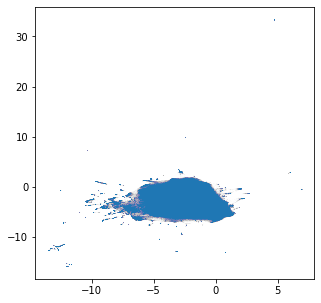

In [15]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
plt.show()

<hr>
<hr>

In [16]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

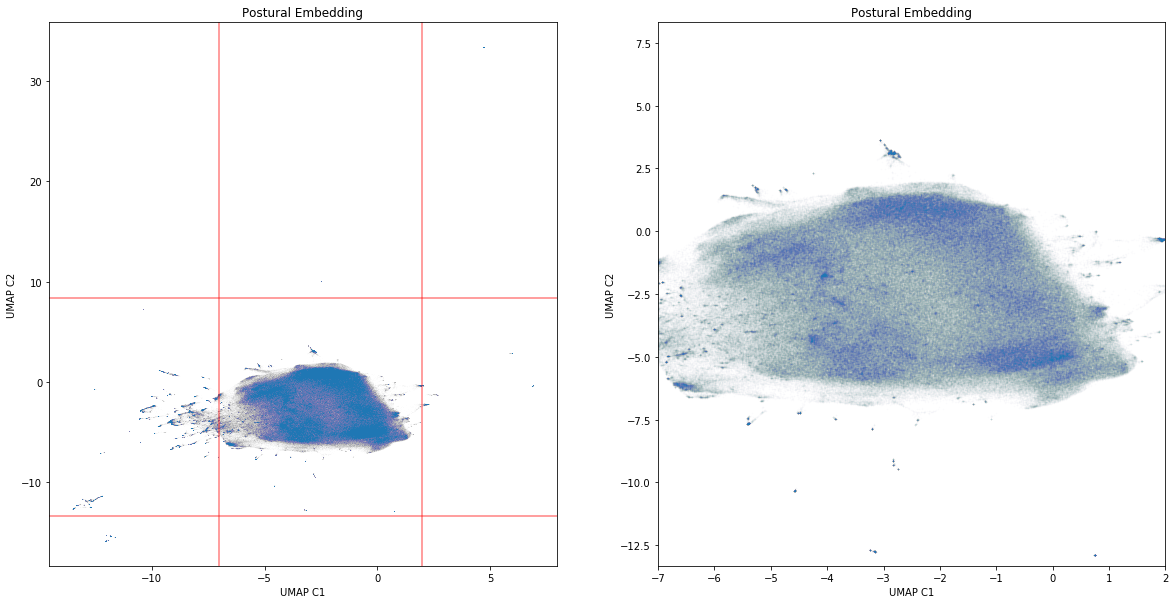

In [22]:
region_x_lim, region_y_lim = (-7,2), (-10,5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=1, alpha=0.005)
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_postural_embed[:,0], all_postural_embed[:,1], s=2, alpha=0.006)
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()